In [ ]:
# TensorFlow makes the colab runtime crash due to an outdated protobuf version.
!pip install -y tensorflow
!pip install -U ludwig[tree,viz] matplotlib "scikit-learn<1.2"


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nv

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Define the number of samples
n_samples = 1000

# Generate dummy data
data = {
    'Water_Temperature': np.random.uniform(0, 30, n_samples),  # °C
    'Salinity': np.random.uniform(30, 35, n_samples),  # ppt
    'Dissolved_Oxygen': np.random.uniform(2, 10, n_samples),  # mg/L
    'pH_Level': np.random.uniform(7.5, 8.5, n_samples),
    'Chlorophyll_Concentration': np.random.lognormal(0, 1, n_samples),  # μg/L
    'Nutrient_Levels': np.random.lognormal(0, 1, n_samples),  # μmol/L
    'Fishing_Pressure': np.random.uniform(0, 168, n_samples),  # hours/week
    'Ocean_Current_Speed': np.random.uniform(0, 2, n_samples),  # m/s
    'Depth': np.random.uniform(0, 200, n_samples),  # m
    'Season': np.random.choice(['Spring', 'Summer', 'Fall', 'Winter'], n_samples)
}

# Create DataFrame
df = pd.DataFrame(data)

# Generate target variable (Fishery Biomass) based on a complex interaction of features
# This is a simplified model and doesn't reflect real-world relationships
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('Season', axis=1))

# Create a complex, non-linear relationship
biomass = (
    5 * scaled_features[:, 0]  # Water Temperature
    - 3 * scaled_features[:, 1]  # Salinity
    + 4 * scaled_features[:, 2]  # Dissolved Oxygen
    - 2 * scaled_features[:, 3]  # pH Level
    + 3 * scaled_features[:, 4]  # Chlorophyll Concentration
    + 2 * scaled_features[:, 5]  # Nutrient Levels
    - 4 * scaled_features[:, 6]  # Fishing Pressure
    + np.sin(scaled_features[:, 7])  # Ocean Current Speed
)

# Add some noise
biomass += np.random.normal(0, 0.5, n_samples)

# Scale biomass to a reasonable range (1 to 100 tons/km²) and add to dataframe
df['Fishery_Biomass'] = (biomass - biomass.min()) / (biomass.max() - biomass.min()) * 99 + 1
df.to_csv('ocean_fishery_data.csv', index=False)

In [ ]:
# Cell 6 - Data Preprocessing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import FunctionTransformer

# Load the data
df = pd.read_csv('ocean_fishery_data.csv')

# Step 1: Check for missing values
print("Missing values:\n", df.isnull().sum())

# Step 2: Outlier detection (using IQR method)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

numerical_columns = df.select_dtypes(include=[np.number]).columns
for column in numerical_columns:
    outliers = detect_outliers(df, column)
    print(f"Outliers in {column}: {len(outliers)}")

# For this example, we'll cap the outliers
for column in numerical_columns:
    lower_bound = df[column].quantile(0.25) - 1.5 * (df[column].quantile(0.75) - df[column].quantile(0.25))
    upper_bound = df[column].quantile(0.75) + 1.5 * (df[column].quantile(0.75) - df[column].quantile(0.25))
    df[column] = df[column].clip(lower_bound, upper_bound)

# Step 3 & 4: Feature scaling and encoding
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('Fishery_Biomass')
categorical_features = ['Season']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Step 5: Feature engineering
def add_interaction(df):
    df['Temp_Salinity_Interaction'] = df['Water_Temperature'] * df['Salinity']
    return df

# Step 6: Feature selection
selector = VarianceThreshold(threshold=0.1)

# Create preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('engineer', FunctionTransformer(add_interaction)),
    ('preprocessor', preprocessor),
    ('selector', selector)
])

# Step 7: Data split
X = df.drop('Fishery_Biomass', axis=1)
y = df['Fishery_Biomass']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply preprocessing
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Get feature names after preprocessing
feature_names = (numeric_features.tolist() +
                 [f'Season_{season}' for season in ['Summer', 'Fall', 'Winter']] +
                 ['Temp_Salinity_Interaction'])
feature_names = [feature_names[i] for i in selector.get_support(indices=True)]

# Create DataFrames with processed data
train_df = pd.DataFrame(X_train_processed, columns=feature_names)
train_df['Fishery_Biomass'] = y_train.values

val_df = pd.DataFrame(X_val_processed, columns=feature_names)
val_df['Fishery_Biomass'] = y_val.values

test_df = pd.DataFrame(X_test_processed, columns=feature_names)
test_df['Fishery_Biomass'] = y_test.values

# Save processed datasets
train_df.to_csv('processed_train_data.csv', index=False)
val_df.to_csv('processed_val_data.csv', index=False)
test_df.to_csv('processed_test_data.csv', index=False)

Missing values:
 Water_Temperature            0
Salinity                     0
Dissolved_Oxygen             0
pH_Level                     0
Chlorophyll_Concentration    0
Nutrient_Levels              0
Fishing_Pressure             0
Ocean_Current_Speed          0
Depth                        0
Season                       0
Fishery_Biomass              0
dtype: int64
Outliers in Water_Temperature: 0
Outliers in Salinity: 0
Outliers in Dissolved_Oxygen: 0
Outliers in pH_Level: 0
Outliers in Chlorophyll_Concentration: 79
Outliers in Nutrient_Levels: 64
Outliers in Fishing_Pressure: 0
Outliers in Ocean_Current_Speed: 0
Outliers in Depth: 0
Outliers in Fishery_Biomass: 3


In [ ]:
import yaml
import logging
from ludwig.api import LudwigModel
from ludwig.backend import LOCAL_BACKEND

gbm_config = {
    'input_features': [
        {'name': 'Water_Temperature', 'type': 'numerical'},
        {'name': 'Salinity', 'type': 'numerical'},
        {'name': 'Dissolved_Oxygen', 'type': 'numerical'},
        {'name': 'pH_Level', 'type': 'numerical'},
        {'name': 'Chlorophyll_Concentration', 'type': 'numerical'},
        {'name': 'Nutrient_Levels', 'type': 'numerical'},
        {'name': 'Fishing_Pressure', 'type': 'numerical'},
        {'name': 'Ocean_Current_Speed', 'type': 'numerical'},
        {'name': 'Depth', 'type': 'numerical'},
        {'name': 'Season_Summer', 'type': 'binary'},
        {'name': 'Season_Fall', 'type': 'binary'},
        {'name': 'Season_Winter', 'type': 'binary'}
    ],
    'output_features': [
        {'name': 'Fishery_Biomass', 'type': 'numerical'}
    ],
    'model_type': 'gbm',
    'trainer': {
        'num_boost_round': 100,
        'learning_rate': 0.1,
        'max_depth': 6,
        'early_stop': 5
    },
    'preprocessing': {
        'numerical': {
            'normalization': 'zscore'
        }
    }
}


In [ ]:
model = LudwigModel(config=gbm_config, logging_level=logging.INFO)
train_stats, preprocessed_data, output_directory = model.train(dataset='processed_train_data.csv')

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

Training:   0%|          | 0/100 [00:00<?, ?it/s]Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[50]	train's l2: 4.75501	train's l1: 1.43234	validation's l2: 16.0522	validation's l1: 2.73351	test's l2: 21.5239	test's l1: 3.27271
Training:  50%|█████     | 50/100 [00:00<00:00, 286.96it/s]

INFO:ludwig.trainers.trainer_lightgbm:
Running evaluation for step: 50, epoch: 0


Evaluation test : 100%|██████████| 1/1 [00:00<00:00, 140.49it/s]

INFO:ludwig.trainers.trainer_lightgbm:Evaluation took 0.7076s

INFO:ludwig.utils.metrics_printed_table:╒════════════════════════════════════╤═════════╤══════════════╤═════════╕
│                                    │   train │   validation │    test │
╞════════════════════════════════════╪═════════╪══════════════╪═════════╡
│ loss                               │  4.7550 │      16.0522 │ 21.5239 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ mean_absolute_error                │  1.4323 │       2.7335 │  3.2727 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ mean_absolute_percentage_error     │  0.0569 │       0.0894 │  0.1169 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ mean_squared_error                 │  4.7550 │      16.0522 │ 21.5239 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ r2                                 │  0.9685 │       0.8776 │  0.8726 │
├────────


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	train's l2: 2.32469	train's l1: 0.977244	validation's l2: 13.4612	validation's l1: 2.45965	test's l2: 16.8031	test's l1: 2.71077
Training: 100%|██████████| 100/100 [00:00<00:00, 297.41it/s]

INFO:ludwig.trainers.trainer_lightgbm:
Running evaluation for step: 100, epoch: 1


Evaluation test : 100%|██████████| 1/1 [00:00<00:00, 108.33it/s]

INFO:ludwig.trainers.trainer_lightgbm:Evaluation took 0.5397s

INFO:ludwig.utils.metrics_printed_table:╒════════════════════════════════════╤═════════╤══════════════╤═════════╕
│                                    │   train │   validation │    test │
╞════════════════════════════════════╪═════════╪══════════════╪═════════╡
│ loss                               │  2.1383 │      13.4612 │ 16.8031 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ mean_absolute_error                │  0.9357 │       2.4597 │  2.7108 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ mean_absolute_percentage_error     │  0.0348 │       0.0787 │  0.0934 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ mean_squared_error                 │  2.1383 │      13.4612 │ 16.8031 │
├────────────────────────────────────┼─────────┼──────────────┼─────────┤
│ r2                                 │  0.9858 │       0.8974 │  0.9005 │
├────────

INFO:ludwig.trainers.trainer_lightgbm:Last improvement of Fishery_Biomass validation mean_squared_error happened 8 step(s) ago.



Training: 100%|██████████| 100/100 [00:00<00:00, 217.76it/s]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒════════════════════════════════════════════╤════════════════════╕
│ Validation feature                         │ Fishery_Biomass    │
├────────────────────────────────────────────┼────────────────────┤
│ Validation metric                          │ mean_squared_error │
├────────────────────────────────────────────┼────────────────────┤
│ Best model step                            │ 100                │
├────────────────────────────────────────────┼────────────────────┤
│ Best model epoch                           │ 2                  │
├────────────────────────────────────────────┼────────────────────┤
│ Best model's validation mean_squared_error │ 13.461166381835938 │
├────────────────────────────────────────────┼────────────────────┤
│ Best model's test mean

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


TrainingStats(training={'Fishery_Biomass': {'loss': [4.755013942718506, 2.138260841369629], 'mean_absolute_error': [1.4323445558547974, 0.935744047164917], 'mean_absolute_percentage_error': [0.05691087618470192, 0.034774571657180786], 'mean_squared_error': [4.755013942718506, 2.138260841369629], 'r2': [0.9684543609619141, 0.9858143925666809], 'root_mean_squared_error': [2.1805994510650635, 1.4622793197631836], 'root_mean_squared_percentage_error': [0.21276596188545227, 0.1111191138625145]}, 'combined': {'loss': [4.755013942718506, 2.138260841369629]}}, validation={'Fishery_Biomass': {'loss': [16.052154541015625, 13.461166381835938], 'mean_absolute_error': [2.733513116836548, 2.4596548080444336], 'mean_absolute_percentage_error': [0.08935519307851791, 0.07868749648332596], 'mean_squared_error': [16.052154541015625, 13.461166381835938], 'r2': [0.8776179552078247, 0.8973717093467712], 'root_mean_squared_error': [4.006514072418213, 3.6689462661743164], 'root_mean_squared_percentage_error':

In [ ]:
model.set_logging_level(logging.ERROR)

train, valid, test, metadata = preprocessed_data
evaluation_statistics, predictions, output_directory = model.evaluate(test, collect_overall_stats=True)

In [ ]:
import ludwig
print(ludwig.__version__)
!pip install dask[dataframe]
from ludwig.visualize import learning_curves, compare_performance, compare_classifiers_predictions

0.10.4


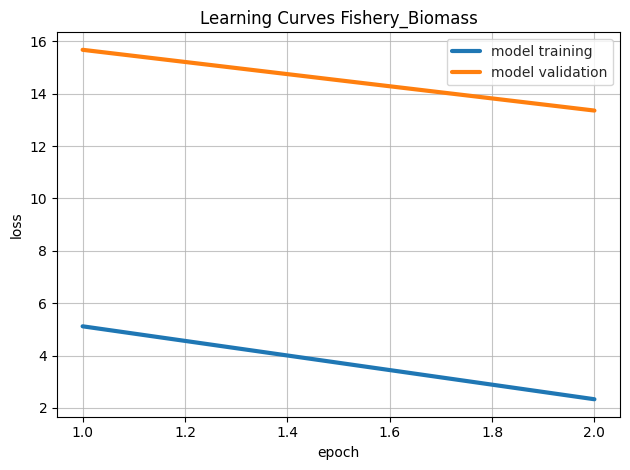

In [ ]:
learning_curves(train_stats, output_feature_name='Fishery_Biomass', model_names='model')